In [1]:
# check them out
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

import numpy as np
import math

Using TensorFlow backend.


In [2]:
PATH_TO_DF = "../data/output_convnet/VGG16"

img_width = 150
img_height = 150

n_epochs = 50
batch_size = 16

train_data_dir = "train"  
validation_data_dir = "validation"
test_data_dir = "test"

n_train_samples = 3000
n_validation_samples = 1000
n_test_samples = 1000
n_classes = 8

In [6]:
import time

ti_bn_features = time.time()

model = InceptionV3(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255)

'''
https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L1002
if PIL version 1.1.3 interpolation = 'lanczos'
else interpolation = 'bicubic' 
''' 

# train
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False,
    interpolation = 'lanczos')

# important step in order to get the exact number
max_queue_size_train = int(math.ceil(n_train_samples / batch_size))

bnfeatures_train = model.predict_generator(
    generator, max_queue_size_train)

np.save('../data/output_convnet/Inception/inception_bnfeatures_train.npy', bnfeatures_train)

# validation
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    interpolation = 'lanczos')

max_queue_size_val = int(math.ceil(n_validation_samples / batch_size))


bnfeatures_val = model.predict_generator(  
     generator, max_queue_size_val)

np.save('../data/output_convnet/Inception/inception_bnfeatures_val.npy', bnfeatures_val)


tf_bn_features = time.time()    
tt_bn_features = tf_bn_features - ti_bn_features

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


In [7]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_features)))

00:00:25


In [8]:
# training top layer
import os

ti_bn_train = time.time()

# we have to get the classes names so we build again a generator
datagen_top_layer = ImageDataGenerator(rescale=1./255)  

# train
generator_top_layer = datagen_top_layer.flow_from_directory(
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False,
    interpolation = 'lanczos')  

train_data = np.load('../data/output_convnet/Inception/inception_bnfeatures_train.npy')

# ref attribute classes --> https://keras.io/preprocessing/image/
train_labels = generator_top_layer.classes # the key attribute
train_labels = to_categorical(train_labels, num_classes=n_classes) # the key function

# validation
generator_top_layer = datagen_top_layer.flow_from_directory(  
    validation_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False,
    interpolation = 'lanczos')  

val_data = np.load('../data/output_convnet/Inception/inception_bnfeatures_val.npy') 

val_labels = generator_top_layer.classes # the key attribute
val_labels = to_categorical(val_labels, num_classes=n_classes) # the key function


# top model, could be with a diff dense, optimizer, momentum -> https://keras.io/optimizers/
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(n_classes, activation='softmax'))  


model.compile(optimizer=SGD(lr=0.001),
              loss='categorical_crossentropy', metrics=['accuracy']) 


historical_data = model.fit(train_data, train_labels,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(val_data, val_labels))  

# h5py
model.save_weights('../data/output_convnet/Inception/inception_bn_model.h5')  

tf_bn_train = time.time()    
tt_bn_train = tf_bn_train - ti_bn_train

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 2s 810us/step - loss: 1.4343 - acc: 0.5513 - val_loss: 0.8317 - val_acc: 0.7690
Epoch 2/50
3000/3000 [==============================] - 2s 503us/step - loss: 0.8116 - acc: 0.7490 - val_loss: 0.6677 - val_acc: 0.8110
Epoch 3/50
3000/3000 [==============================] - 2s 531us/step - loss: 0.6434 - acc: 0.8010 - val_loss: 0.5998 - val_acc: 0.8100
Epoch 4/50
3000/3000 [==============================] - 2s 577us/step - loss: 0.5259 - acc: 0.8413 - val_loss: 0.5362 - val_acc: 0.8250
Epoch 5/50
3000/3000 [==============================] - 2s 510us/step - loss: 0.4401 - acc: 0.8600 - val_loss: 0.5046 - val_acc: 0.8210
Epoch 6/50
3000/3000 [==============================] - 2s 516us/step - loss: 0.3925 - acc: 0.8833 - val_loss: 0.4869 - val_acc: 0.8360
Epoch 7/50
3000/3000 [==============================

In [9]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_train)))

00:01:19


In [10]:
import h5py
hdf5_file = h5py.File('../data/output_convnet/Inception/inception_bn_model.h5', mode='r')
print(list(hdf5_file))

['dense_1', 'dense_2', 'dropout_1', 'flatten_1']


In [11]:
(loss, acc) = model.evaluate(val_data, val_labels, batch_size=batch_size, verbose=0)
print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))  

acc: 86.30% - loss: 0.410055


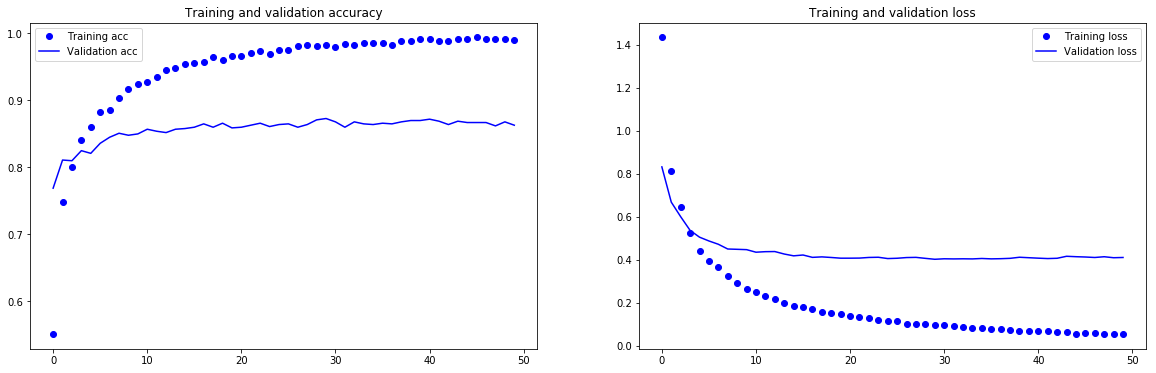

In [13]:
# historical_data.history acc and loss data over the epochs (train and validation)
import matplotlib.pyplot as plt

train_acc = historical_data.history['acc']
train_loss = historical_data.history['loss']

val_acc = historical_data.history['val_acc'] # validation
val_loss = historical_data.history['val_loss'] # validation

range_epochs = range(n_epochs)

fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plt.plot(range_epochs, train_acc, 'bo', label='Training acc')
plt.plot(range_epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1,2,2)
plt.plot(range_epochs, train_loss, 'bo', label='Training loss')
plt.plot(range_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig(os.path.join(PATH_TO_DF, "inception_bn_acc_loss.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb
plt.show()

In [ ]:
top_model_weights_path = '../data/output_convnet/bn_inception_model.h5'

batch_size = 5 # con 5 funciona con 16 es imposible probar con 10

In [ ]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input

In [ ]:
input_tensor = Input(shape=(img_width,img_height,3))
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
print("model loaded")

In [ ]:
base_model.output_shape[1:]

In [ ]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# for i, layer in enumerate(base_model.layers):
#     print (i, layer.name, layer.output_shape)

In [ ]:
for i, layer in enumerate(top_model.layers):
    print (i, layer.name, layer.output_shape)

In [ ]:
top_model.load_weights("../data/output_convnet/bn_inception_model.h5")

In [ ]:
model_total = Model(input= base_model.input, output= top_model(base_model.output))

In [ ]:
for layer in model_total.layers[:280]:
    layer.trainable = False
for layer in model_total.layers[280:]:
    layer.trainable = True

In [ ]:
# for i, layer in enumerate(model_total.layers):
#     if layer.trainable:
#         print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
#     else:
#         print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

In [ ]:
model_total.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

In [ ]:
import time
# fine-tune the model

# añadir medidas de acc loss como el bottleneck

ti_ftuning = time.time()


historical_data = model_total.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    verbose = 1,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples)

tf_ftuning = time.time()
tt_ftuning = tf_ftuning - ti_ftuning
print(time.strftime("%H:%M:%S", time.gmtime(tt_ftuning)))

In [ ]:
import matplotlib.pyplot as plt
PATH_TO_DF = "../data/output_convnet"

acc = historical_data.history['acc']
val_acc = historical_data.history['val_acc']
loss = historical_data.history['loss']
val_loss = historical_data.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_total.save_weights('../data/output_convnet/ft_inception_model.h5')

In [ ]:
import h5py
hdf5_file = h5py.File('../data/output_convnet/ft_inception_model.h5', mode='r')
print(list(hdf5_file))

In [ ]:
# build the VGG16 network
# input_tensor = Input(shape=(img_width,img_height,3))
model_base_pred = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)  
print("model base for predition loaded")

# build top model  
top_model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dense(num_classes, activation='softmax'))
print()
print("model top for predition loaded")

In [ ]:
model_total_pred = Model(input= model_base_pred.input, output= top_model(model_base_pred.output))

In [ ]:
# for i, layer in enumerate(model_total_pred.layers):
#     print (i, layer.name, layer.output_shape)

In [ ]:
# cargamos los pesos anteriormente obtenidos en el entrenamiento
model_total_pred.load_weights("../data/output_convnet/ft_inception_model.h5")

In [ ]:
test_data_dir = 'test/'
batch_size_test = 5 # probamos con esto

test_convnet = ImageDataGenerator(rescale=1. / 255)

test_generator = test_convnet.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle =False,
    class_mode='categorical')

cat_dict = test_generator.class_indices

inverse_coding = {v: k for k, v in cat_dict.items()}

In [ ]:
import os

test_data_dir = "test/"

# listado del train
img_test_real = [] # listado de las imagenes pareado con img_cat_real
img_cat_real = [] # categorias de las imagenes


img_cat_pred = [] # elementos predichos por la convnet

img_folder = sorted([folder for folder in os.listdir(test_data_dir)
                  if os.path.isdir(os.path.join(test_data_dir, folder))])

for index_folder, category in enumerate(img_folder):
    
    folder = os.path.join(test_data_dir, category)

    for index_img, img in enumerate(os.listdir(folder)):
        
        if img.endswith(".tif"): # just in case there are other kind of files like .db
            img_test_real.append(os.path.join(folder, img))
            img_cat_real.append(img_folder[index_folder])

    print("Category {0:s} has {1:d} images.".format(category, index_img+1))

In [ ]:
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input

In [ ]:
print(len(img_cat_pred))
print(len(img_test_real))

In [ ]:
for index, img_path in enumerate(img_test_real):
    
    
    if not index % 100:
        print("image {0:d} processed".format(index))
        
    # pre process
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    x = x / 255
    
    # prediction
    x = model_total_pred.predict(x)
    
    # label
    label = inverse_coding[np.argmax(x)]
    
#     print(label)
    
    # store the label
    img_cat_pred.append(label)
    

In [ ]:
print(len(img_cat_pred))
print(len(img_test_real))

In [ ]:
img_cat_pred_arr = np.array(img_cat_pred)
img_cat_real_arr = np.array(img_cat_real)

In [ ]:
print(len(img_cat_pred_arr))
print(len(img_cat_real_arr))

In [ ]:
from sklearn.metrics import confusion_matrix
ft_conf_mat = confusion_matrix(img_cat_real_arr,img_cat_pred_arr)

In [ ]:
ft_conf_mat

In [ ]:
# reference http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)

In [ ]:
PATH_TO_IMG = "../data/input_dataset"
class_names = sorted([folder for folder in os.listdir(PATH_TO_IMG)
                      if os.path.isdir(os.path.join(PATH_TO_IMG, folder))])

In [ ]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plot_confusion_matrix(ft_conf_mat, classes=class_names, title='Confusion matrix')

fig.add_subplot(1,2,2)
plot_confusion_matrix(ft_conf_mat, classes=class_names, normalize=True, title='Confusion matrix')

plt.savefig(os.path.join(PATH_TO_DF, "ft_confmat_VGG16.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# print(classification_report(y_test, pred_categorical))
# print("The total accuracy is", accuracy_score(y_test, pred_categorical))